In [5]:
from tl_tools import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
setup_mixed_precision()

Mixed precision policy set to: mixed_float16



In [6]:
resnet_path = '/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/code/transfer_learning/resnet34v2.keras'
resnet34v2 = load_model(resnet_path)

import os
os.makedirs('fc_weights', exist_ok= True)

resnet34v2_fc_layers = resnet34v2.layers[-7:]
fc_model = Sequential(resnet34v2_fc_layers)
fc_model.save_weights('fc_weights/fc_layers.weights.h5')

In [7]:
test_dir = '/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/data/USTC_SmokeRS/processed/test'
test_datagen = ImageDataGenerator(rescale=1./255)
test = test_datagen.flow_from_directory(test_dir, color_mode= 'rgb', batch_size = 16, shuffle= True, seed = 1, target_size=(256, 256))
X_test, y_test = test_splits(test)

Found 1245 images belonging to 6 classes.
Number of batches in the test data: 78
Batch size of a single batch 16
Number of samples in the test dataset 1245

Shape of image test set: (1245, 256, 256, 3)

Shape of label test set: (1245, 6)


In [8]:
pred = tf.argmax(resnet34v2.predict(X_test), axis = 1).numpy()
y_true = tf.argmax(y_test, axis=1).numpy()

39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step


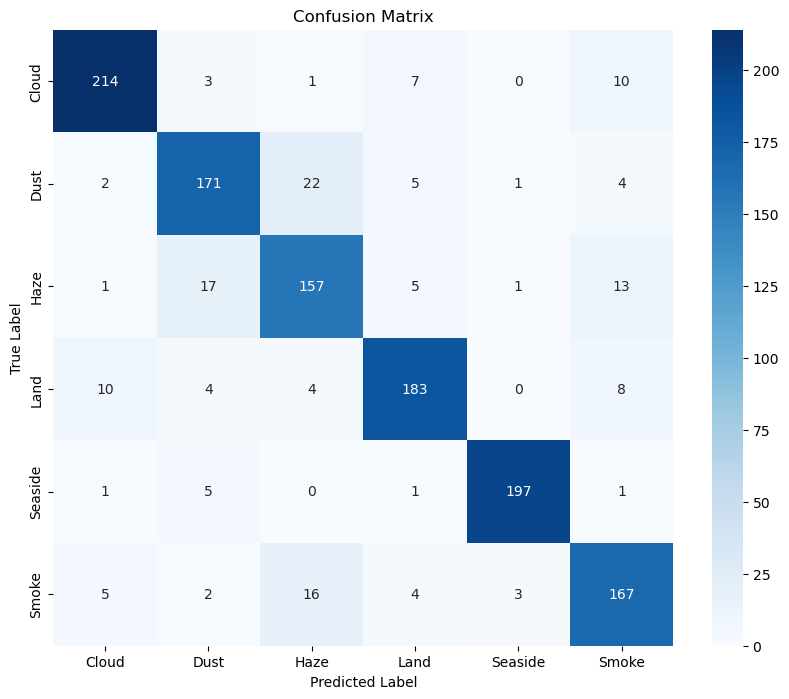

In [9]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class_labels = list(test.class_indices.keys())
confusion_matrix = confusion_matrix(pred, y_true)


plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [10]:
n_classes = len(class_labels)
FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.sum() - (FP + FN + TP)

metrics = ['Precision', 'Recall', 'F1-score', 'False Negative Rate']

df_metrics = pd.DataFrame(index=metrics, columns=class_labels)

for i in range(n_classes):
    df_metrics.iloc[0, i] = TP[i] / (TP[i] + FP[i])
    df_metrics.iloc[1, i] = TP[i] / (TP[i] + FN[i])
    df_metrics.iloc[2, i] = 2 * TP[i] / (2 * TP[i] + FP[i] + FN[i])
    df_metrics.iloc[3, i] = FN[i] / (FN[i] + TP[i])  # False Negative Rate

def round_fn(input): 
    return round(input, 4)

df_metrics = df_metrics.map(round_fn)
df_metrics

,Cloud,Dust,Haze,Land,Seaside,Smoke
Precision,0.9185,0.8465,0.7850,0.8927,0.9752,0.8227
Recall,0.9106,0.8341,0.8093,0.8756,0.9610,0.8477
F1-score,0.9145,0.8403,0.7970,0.8841,0.9681,0.8350
False Negative Rate,0.0894,0.1659,0.1907,0.1244,0.0390,0.1523


In [11]:
from sklearn.metrics import accuracy_score

print(f'Accuracy Score: {accuracy_score(pred, y_true):.4f}')
for index, row in df_metrics.iterrows(): 
    row_mean = row.mean()
    print(f'Average {index} Score: {row_mean:.4f}')

Accuracy Score: 0.8747
Average Precision Score: 0.8734
Average Recall Score: 0.8730
Average F1-score Score: 0.8732
Average False Negative Rate Score: 0.1269


In [12]:
feature_extractor = Model(inputs=resnet34v2.input, outputs=resnet34v2.get_layer('global_average_pooling2d_1').output)
feature_extractor_pred = feature_extractor.predict(X_test)

39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
feature_extractor_pred = scaler.fit_transform(feature_extractor_pred)
feature_extractor_df = pd.DataFrame(feature_extractor_pred)
y_true_series = pd.Series(y_true)

class_mapping = dict()
for i, label in enumerate(class_labels): 
    class_mapping[i] = label

y_true_labels = y_true_series.map(class_mapping)

In [14]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2, random_state= 1, perplexity= 30, max_iter = 2000, learning_rate= 'auto', init = 'pca')
X_tsne = tsne.fit_transform(feature_extractor_df)
tsne_df = pd.DataFrame(data = {
    'x1': X_tsne[:, 0], 
    'x2': X_tsne[:, 1], 
    'class': y_true_series
})

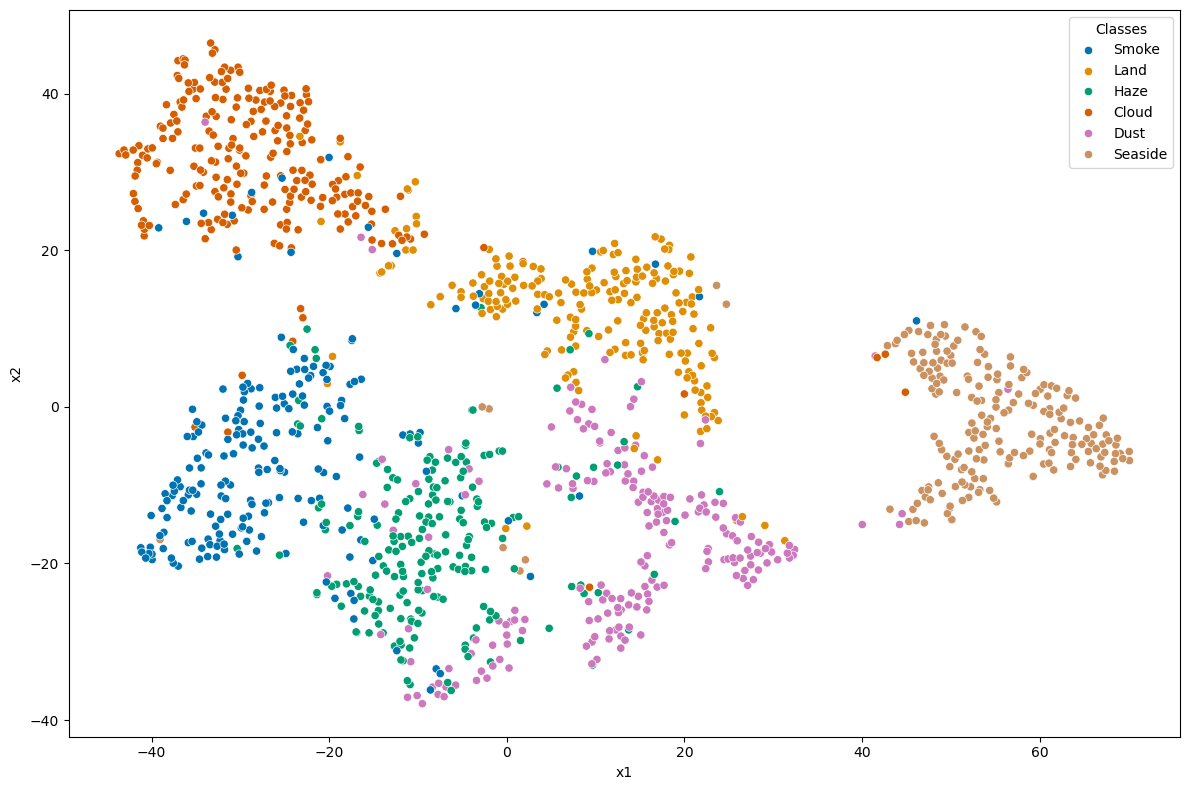

In [15]:
plt.figure(figsize= (12, 8))
scatter = sns.scatterplot(x = 'x1', y = 'x2', data = tsne_df, hue = y_true_labels, palette = 'colorblind')
scatter.legend(title = 'Classes')
plt.tight_layout()
plt.show()

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Your existing code
features = tsne_df[['x1','x2']]
kmeans = KMeans(n_clusters=6, max_iter=1500, random_state=1)
kmeans.fit(features)

# Get cluster labels
cluster_labels = kmeans.labels_

# Calculate evaluation metrics
silhouette = silhouette_score(features, cluster_labels)
calinski = calinski_harabasz_score(features, cluster_labels)
davies = davies_bouldin_score(features, cluster_labels)

# Print results
print(f"Silhouette Score: {silhouette:.3f}")
print(f"Calinski-Harabasz Score: {calinski:.3f}")
print(f"Davies-Bouldin Score: {davies:.3f}")

# Compare with true labels
true_labels = pd.factorize(tsne_df['class'])[0]
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)

print(f"Adjusted Rand Index: {ari:.3f}")
print(f"Normalized Mutual Information: {nmi:.3f}")

Silhouette Score: 0.537
Calinski-Harabasz Score: 2649.765
Davies-Bouldin Score: 0.668
Adjusted Rand Index: 0.668
Normalized Mutual Information: 0.673
